# OSP model



In [1]:
%load_ext lab_black
import tensorflow as tf
import numpy as np
import pandas as pd
from meta import gpu_mem_cap

gpu_mem_cap(2048)  # Put memory cap to allow parallel run

1 Physical GPUs, 1 Logical GPUs


### Parameters block for Papermill
- Instead of using model_cfg directly, this extra step is needed for batch run using Papermill
- Consider carefully the variable type in each cfg setting 
    - Do not use integer (e.g., 1, 2, 3, 0) in variables that can be float32 (e.g., w_oh_noise, tau...)
    - Use integer with a dot instead (e.g., 1., 2., 3., 0.)
- To use attractor, two params must be config, 
    - 1) embed_attractor_cfg --> json cfg file of the pretrain attractor 
    - 2) embed_attractor_h5 --> h5 file of the exact weight (e.g. ep0500.h5)

In [2]:
code_name = 'boo'

sample_name = 'hs04'
sample_rng_seed = 329
tf_rng_seed = 123

# Semantic formula
use_semantic = False
sem_param_gf = 0.
sem_param_gi = 0.
sem_param_kf = 0.
sem_param_ki = 0.
sem_param_hf = 0.
sem_param_hi = 0.

# Model architechture
o_input_dim = 119
hidden_units = 100
pho_units = 250
cleanup_units = 50
rnn_activation = 'sigmoid'
regularizer_const = 0.

embed_attractor_cfg = None
embed_attractor_h5 = None

# embed_attractor_cfg = 'models/Attractor_50/model_config.json'
# embed_attractor_h5 = 'ep0500.h5'

p_noise = 0.  # i.e. w_pp, w_pc, and w_cp noise
tau = 0.2
max_unit_time = 4.

# Training
n_mil_sample = 1.
batch_size = 128
learning_rate = 0.005
save_freq = 5

# Results push to BQ database
bq_dataset = None

### Packing parameters into model_cfg

In [3]:
from meta import model_cfg

cfg = model_cfg(
    code_name=code_name,
    sample_name=sample_name,
    sample_rng_seed=sample_rng_seed,
    tf_rng_seed=tf_rng_seed,
    use_semantic=use_semantic,
    sem_param_gf=sem_param_gf,
    sem_param_gi=sem_param_gi,
    sem_param_kf=sem_param_kf,
    sem_param_ki=sem_param_ki,
    sem_param_hf=sem_param_hf,
    sem_param_hi=sem_param_hi,
    o_input_dim=o_input_dim,
    hidden_units=hidden_units,
    pho_units=pho_units,
    cleanup_units=cleanup_units,
    embed_attractor_cfg=embed_attractor_cfg,
    embed_attractor_h5=embed_attractor_h5,
    w_oh_noise=0.,
    w_hp_noise=0.,
    w_pp_noise=p_noise,
    w_pc_noise=p_noise,
    w_cp_noise=p_noise,
    tau=tau,
    max_unit_time=max_unit_time,
    n_mil_sample=n_mil_sample,
    batch_size=batch_size,
    rnn_activation=rnn_activation,
    regularizer_const=regularizer_const,
    learning_rate=learning_rate,
    save_freq=save_freq,
    bq_dataset=bq_dataset
)

# TF random seed (Sampling is out of TF scope... change sample_rng_seed instead)
tf.random.set_seed(cfg.tf_rng_seed)

# Preload data
from data_wrangling import sample_generator, my_data
data = my_data(cfg)

==========Orthographic representation==========
x_train shape: (5832, 119)
x_strain shape: (160, 119)
x_grain shape: (120, 119)

==========Phonological representation==========
38  phonemes:  dict_keys(['h', 'y', 't', 'T', 'J', 'p', 'b', 'D', 'e', 'U', 'g', 'C', 'Y', 'm', 's', '_', 'E', 'l', 'k', 'i', 'n', 'S', 'A', '^', 'Z', 'w', 'f', 'O', 'o', 'W', 'I', '@', 'd', 'a', 'u', 'r', 'v', 'z'])
y_train shape: (5832, 250)
y_strain shape: (160, 250)
y_large_grain shape: (120, 250)
y_small_grain shape: (120, 250)


# Modeling

## Building

In [4]:
def build_model(training=True):
    # Organization principal:
    # Structure things, such as repeat vector should build within the model
    # Static calculation of input --> Easier to modify --> build within sample generator

    from tensorflow.keras import Model
    from tensorflow.keras.layers import Layer, Input, concatenate, multiply, RepeatVector
    from tensorflow.keras.optimizers import Adam
    from modeling import rnn
    #     from modeling_without_cleanup import rnn_no_cleanup_no_pp

    # Train/test mode checking
    cfg.noise_on() if training is True else cfg.noise_off()

    input_o = Input(shape=(cfg.o_input_dim, ), name="Input_O")
    input_o_t = RepeatVector(cfg.n_timesteps, name='Input_Ot')(input_o)

    if cfg.use_semantic == True:
        raw_s_t = Input(shape=(cfg.n_timesteps, cfg.pho_units), name='Plaut_St')

        input_p = Input(shape=(cfg.pho_units, ), name='input_P')
        input_p_t = RepeatVector(cfg.n_timesteps, name='Teaching_Pt')(input_p)

        input_s_t = multiply([raw_s_t, input_p_t], name='Input_St')

        combined = concatenate([input_o_t, input_s_t], name='Combined_input')
        rnn_model = rnn(cfg)(combined)
        model = Model([input_o, raw_s_t, input_p], rnn_model)

    else:
        rnn_model = rnn(cfg)(input_o_t)
        model = Model(input_o, rnn_model)

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(
            learning_rate=cfg.learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            amsgrad=False
        ),
        metrics=['BinaryAccuracy', 'mse']
    )

    model.summary()
    return model


model = build_model(training=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_O (InputLayer)         [(None, 119)]             0         
_________________________________________________________________
Input_Ot (RepeatVector)      (None, 20, 119)           0         
_________________________________________________________________
rnn (rnn)                    [(1, 250), (None, 250), ( 124800    
Total params: 124,800
Trainable params: 124,800
Non-trainable params: 0
_________________________________________________________________


## Arming attractor

In [5]:
if cfg.embed_attractor_cfg is not None:
    print('Found attractor info in config (cfg), arming attractor...')
    from modeling import attractor, arm_attractor
    from evaluate import plot_variables

    attractor_cfg = model_cfg(None)
    attractor_cfg.load_cfg_json(cfg.embed_attractor_cfg)
    attractor_obj = attractor(attractor_cfg, cfg.embed_attractor_h5)

    model = arm_attractor(model, attractor_obj)
    plot_variables(model)
else:
    print('Config indicates no attractor, I have do nothing.')

Config indicates no attractor, I have do nothing.


## Training

In [6]:
import h5py, pickle, os
from tensorflow.keras.callbacks import ModelCheckpoint
from data_wrangling import sample_generator
from IPython.display import clear_output

checkpoint = ModelCheckpoint(
    cfg.path_weights_checkpoint,
    verbose=1,
    save_freq=cfg.save_freq_sample,
    save_weights_only=True
)

history = model.fit(
    sample_generator(cfg, data),
    steps_per_epoch=cfg.steps_per_epoch,
    epochs=cfg.nEpo,
    verbose=0,
    callbacks=[checkpoint]
)

# Saving history and model
pickle_out = open(cfg.path_history_pickle, "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

clear_output()
print('Training done')

Training done


# Reporting

### Training history

In [7]:
from evaluate import training_history

hist = training_history(cfg.path_history_pickle)
hist.plot_all(cfg.path_plot_folder + 'history.html')

alt.HConcatChart(...)

### Parse item level stats

In [8]:
# Must turn training mode off before evaluation
model = build_model(training=False)
from evaluate import strain_eval, grain_eval

# Strain full model
strain = strain_eval(cfg, data, model)
strain.start_evaluate(
    test_use_semantic=True,
    output=cfg.path_model_folder + 'result_strain_item.csv'
)

All done 

Saved file to models/O2P_revisiting_weight_decay_0/result_strain_item.csv


In [9]:
# Semantic lesion in Strain
strain_ns = strain_eval(cfg, data, model)
strain_ns.start_evaluate(
    test_use_semantic=False,
    output=cfg.path_model_folder + 'result_strain_ns_item.csv'
)

All done 

Saved file to models/O2P_revisiting_weight_decay_0/result_strain_ns_item.csv


In [10]:
# Grain
model = build_model(training=False)
from evaluate import strain_eval, grain_eval
grain = grain_eval(cfg, data, model)
grain.start_evaluate(
    test_use_semantic=False,
    output=cfg.path_model_folder + 'result_grain_item.csv'
)

All done 

Saved file to models/O2P_revisiting_weight_decay_0/result_grain_item.csv


### Strain plots

In [11]:
from evaluate import vis

vis_ns = vis(
    cfg.path_model_folder, 'result_strain_ns_item.csv', 'result_grain_item.csv'
)

vis = vis(
    cfg.path_model_folder, 'result_strain_item.csv', 'result_grain_item.csv'
)

vis_ns.parse_cond_df()
vis.parse_cond_df()

full = vis.plot_dev('acc').properties(title='Full input')
lesion = vis_ns.plot_dev('acc').properties(title='Semantic lesion')

strain_plot = full | lesion
strain_plot.save(cfg.path_plot_folder + 'strain.html')
strain_plot

alt.HConcatChart(...)

### Lesion development deep dive

In [12]:
dev_inter = vis_ns.plot_dev_interactive('acc')
dev_inter.save(cfg.path_plot_folder + 'interactive_strain_dev.html')
dev_inter

alt.Chart(...)

### Lesion time plot deep dive

In [13]:
time_inter = vis_ns.plot_time_interactive('acc')
time_inter.save(cfg.path_plot_folder + 'interactive_strain_time.html')
time_inter

alt.Chart(...)

### Grain plots

In [14]:
small = vis.plot_dev('acc_small_grain', exp='grain')
large = vis.plot_dev('acc_large_grain', exp='grain')
grain_plot = small | large
grain_plot.save(cfg.path_plot_folder + 'grain.html')
grain_plot

alt.HConcatChart(...)

### Imageability effect

In [15]:
# vis.parse_cond_df(cond_strain='cond_img')
# vis.plot_dev('acc', exp='strain')

### Frequency effect

In [16]:
# vis.parse_cond_df(cond_strain='cond_wf')
# vis.plot_dev('acc', exp='strain')

### Phonological regularity effect

In [17]:
# vis.parse_cond_df(cond_strain='cond_pho')
# vis.plot_dev('acc', exp='strain')

### Model weights and biases

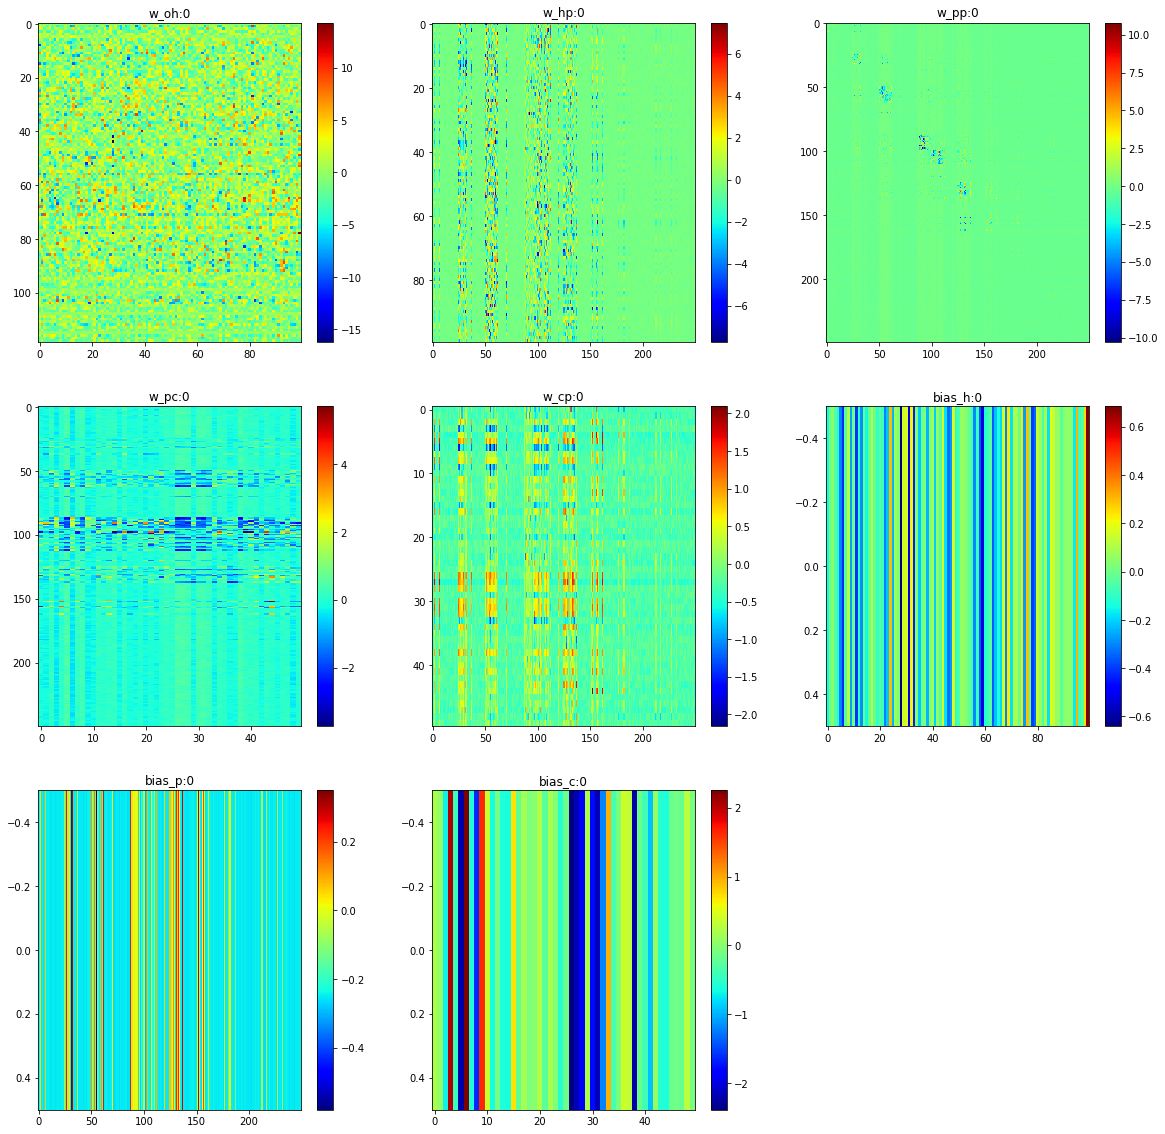

In [18]:
from evaluate import plot_variables
plot_variables(model, cfg.path_plot_folder + 'variables.png')

# Saving results

### Write notebook to html (Must save notebook first)

In [19]:
# # Only work for manual run
# !jupyter nbconvert --to html --ExecutePreprocessor.store_widget_state=True --output-dir=$cfg.path_model_folder basicOSP_master.ipynba

### Push results to GCP-BQ

In [20]:
# if cfg.bq_dataset is not None:
#     from meta import write_all_to_bq

#     for attempt in range(10):
#         try:
#             write_all_to_bq(cfg, strain.i_hist, grain.i_hist)
#             print('Results pushed to BQ')
#         except:
#             from time import sleep
#             sleep(10)
#         else:
#             break